<a href="https://colab.research.google.com/github/Aadit3003/GoogLeNet-implementation/blob/main/InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import TensorBoard

from keras.layers import Conv2D, MaxPool2D, Concatenate, AveragePooling2D, Dropout, Dense, GlobalAveragePooling2D, Flatten

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math


# Dataset Exploration

In [ ]:
train_ds, test_ds = tfds.load("cifar10", split = ['train','test'], as_supervised= True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteWRRHGZ/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteWRRHGZ/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


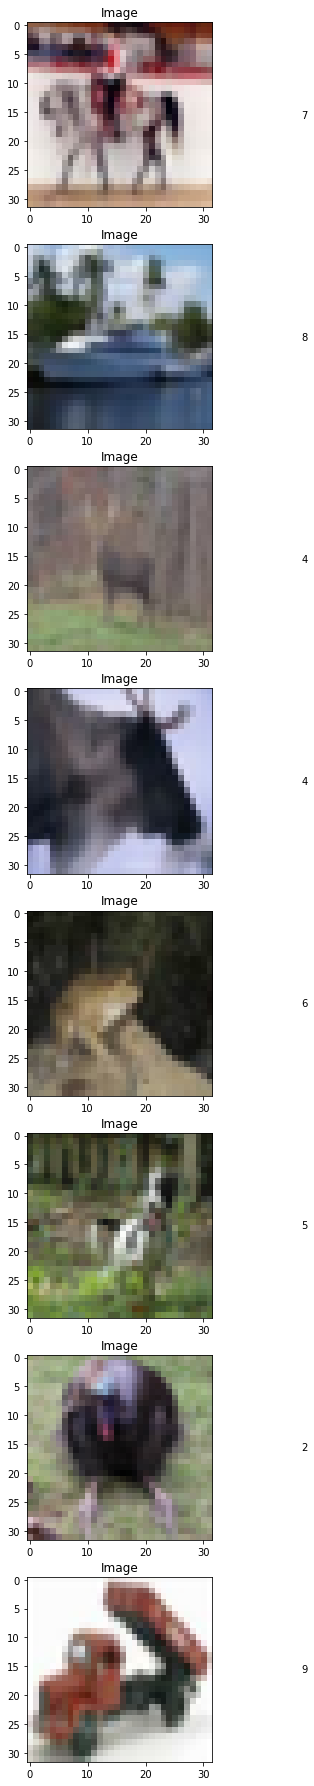

In [ ]:
n = 8
fig, axs = plt.subplots(n, 1, figsize = (4, 4*n))
ds = train_ds.take(n)
i=0

for image, label in ds:
  axs[i].set_title("Image")
  axs[i].imshow(image)
  label = label.numpy()
  axs[i].text(1.5, 0.5, label,
              horizontalalignment='center',
     verticalalignment='center',
     transform = axs[i].transAxes)
  i = i+1

In [ ]:
# Mapping Functions
@tf.function
def normalize_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    image = tf.image.resize(image, [224, 224])
    return image, label

train = train_ds.map(normalize_resize).cache().batch(64)
test = test_ds.map(normalize_resize).cache().batch(64)

In [ ]:
n = 8
ds = train.take(n)

images = []
labels = []

for image, label in ds:
  label = label.numpy()
  images.append(image)
  labels.append(label)

# Inception Net

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.constant(value = 0.2)

In [ ]:
def conv_block(inputs, n_filters, name=None, filter_size = (1,1), stride_step = (1,1), padding_type='same'):
    x = Conv2D(n_filters, filter_size, padding=padding_type, strides = stride_step, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init, name=name)(inputs)
    return x

In [ ]:
def auxiliary_block(inputs, n_classes, name):
    pool = AveragePooling2D(pool_size=(5,5), strides=(3,3))(inputs)
    conv = conv_block(pool, 128)
    flat = Flatten()(conv)
    fc_1 = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.7)(fc_1)
    fc_2 = Dense(n_classes, activation = 'softmax', name=name)(dropout)
    
    return fc_2

In [ ]:
def inception_module(x,
                     n_filters_1x1,
                     n_filters_3x3_reduce,
                     n_filters_3x3,
                     n_filters_5x5_reduce,
                     n_filters_5x5,
                     n_filters_pool_1x1, name):
    

  conv_1x1 = conv_block(x, n_filters_1x1)

  conv_3R = conv_block(x, n_filters_3x3_reduce)
  conv_3x3 = conv_block(conv_3R, n_filters_3x3, filter_size=(3,3))

  conv_5R = conv_block(x, n_filters_5x5_reduce)
  conv_5x5 = conv_block(conv_5R, n_filters_5x5,  filter_size=(5,5))

  max_pool = MaxPool2D(pool_size=(3, 3), strides=(1,1), padding='same')(x)
  pool_conv_1x1 = conv_block(max_pool, n_filters_pool_1x1)

  output = Concatenate(axis = 3, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_conv_1x1])

  return output

In [ ]:
def inception_net(input_size=(224,224,3), n_classes=1000):
    
    inputs = keras.layers.Input(input_size)
    conv_1 = conv_block(inputs, 64,"Conv_1", (7,7), (2,2))

    pool_1 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same', name="Pool_1")(conv_1)
    pool_1 = tf.nn.local_response_normalization(pool_1, name="Local Resp Norm_1")
    conv_2a = conv_block(pool_1, 64, "Conv_2a", padding_type= 'valid')
    conv_2b = conv_block(conv_2a, 192,"Conv_2b", (3,3))    
    conv_2b = tf.nn.local_response_normalization(conv_2b, name="Local Resp Norm_2")
    
    pool_2 = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same', name= "Pool_2")(conv_2b)
    inception_3a = inception_module(pool_2, 64, 96, 128, 16, 32, 32, name= "Inception_3a")
    inception_3b = inception_module(inception_3a, 128, 128, 192, 32, 96, 64, name= "Inception_3b")
    
    pool_3 = MaxPool2D(pool_size=(3,3), strides= (2,2), padding='same', name="Pool_3")(inception_3b)
    inception_4a = inception_module(pool_3, 192, 96, 208, 16, 48, 64, name= "Inception_4a")
    inception_4b = inception_module(inception_4a, 160, 112, 224, 24, 64, 64, name= "Inception_4b")
    inception_4c = inception_module(inception_4b, 128, 128, 256, 24, 64, 64, name= "Inception_4c")
    inception_4d = inception_module(inception_4c, 112, 144, 288, 32, 64, 64, name= "Inception_4d")
#     Auxiliary Classifier
    # soft_0 = auxiliary_block(inception_4d, n_classes, "Soft_0");
    inception_4e = inception_module(inception_4d, 256, 160, 320, 32, 128, 128, name= "Inception_4e")
#     Auxiliary Classifier
    # soft_1 = auxiliary_block(inception_4e, n_classes, "Soft_1");
    
    pool_4 = MaxPool2D(pool_size= (3,3), strides= (2,2), padding='same', name="Pool_4")(inception_4e)
    inception_5a = inception_module(pool_4, 256, 160, 320, 32, 128, 128, name= "Inception_5a")
    inception_5b = inception_module(inception_5a, 384, 192, 384, 48, 128, 128, name= "Inception_5b")
    
    pool_5 = AveragePooling2D(pool_size=(7,7), strides=(1,1), padding='valid', name="Pool_5")(inception_5b)
    drop_out = Dropout(0.4, name="Dropout")(pool_5)
    soft_2 = Dense(n_classes, activation='softmax', name="Soft_2")(drop_out)
    soft_2 = Flatten()(soft_2)
#     With Aux Classifiers
    # model = keras.Model(inputs = inputs, outputs = [soft_2, soft_1, soft_0])

    model = keras.Model(inputs = inputs, outputs = soft_2)

    return model

inception_net()

In [ ]:
inception_net_model = inception_net(n_classes=10)


In [ ]:
inception_net_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
Pool_1 (MaxPooling2D)           (None, 56, 56, 64)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
tf.nn.local_response_normalizat (None, 56, 56, 64)   0           Pool_1[0][0]                     
____________________________________________________________________________________________

#Train the model

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


lr_sc = tf.keras.callbacks.LearningRateScheduler(decay, verbose=1)

In [ ]:
checkpoint_path = "C:/Users/aadit/Google Drive (f20190077@pilani.bits-pilani.ac.in)/Personal Projects/Inception/Saved Model CIFAR10/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

inception_net_model.compile(
    optimizer=sgd,
     loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

print("done")

done


In [ ]:
subset_train = train.take(1000)
subset_test = test.take(1000)

In [ ]:
print(train)
print(test)

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
epochs = 25
inception_net_model.fit(subset_train, validation_data=subset_test, epochs=epochs, batch_size=64, callbacks = [tensorboard_callback, cp_callback, lr_sc])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
os.listdir(checkpoint_dir)

#Predict, Results


In [ ]:
def labels_from_preds(predictions, show):
  labels = []
  for prediction in predictions:
    max, m_i = label_from_pred(prediction, show)
    labels.append(m_i)

  return labels


In [ ]:
def label_from_pred(prediction, show):
  dataset_labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
  max, m_i = max_index(prediction)
  label = dataset_labels[m_i]
  if show:
    print("Label: ",m_i,"(",label,")", " Likelihood:",max)
  return max, m_i


In [ ]:
def max_index(list):
  max = -1
  max_index = 0
  for i in range(len(list)):
    if list[i]>max:
      max = list[i]
      max_index = i
  
  return max, max_index

# Test the model

In [ ]:
inception_net_model.load_weights(checkpoint_path)

In [ ]:
# im_tensor = tf.convert_to_tensor(images)
# print(im_tensor.shape)
# print("Actual labels: ",labels)
# for image in images:
#   preds = inception_net_model.predict(image)
  # print(preds)
  # y_pred = labels_from_preds(preds, show= True)
  # print(y_pred)
# y_pred = labels_from_preds(preds, show= True)
# print("Untrained Model")
# print("Predicted labels: ",y_pred)